In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

In [8]:
# setting up default plotting parameters

%matplotlib inline
plt.rcParams['figure.figsize'] = [20.0, 7.0]
plt.rcParams.update({'font.size': 22,})
sns.set_palette('viridis')
sns.set_style('white')
sns.set_context('talk', font_scale=0.8)

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [15]:
# inspect data types station
inspector = inspect(engine)
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [16]:
# inspect data types measurement
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

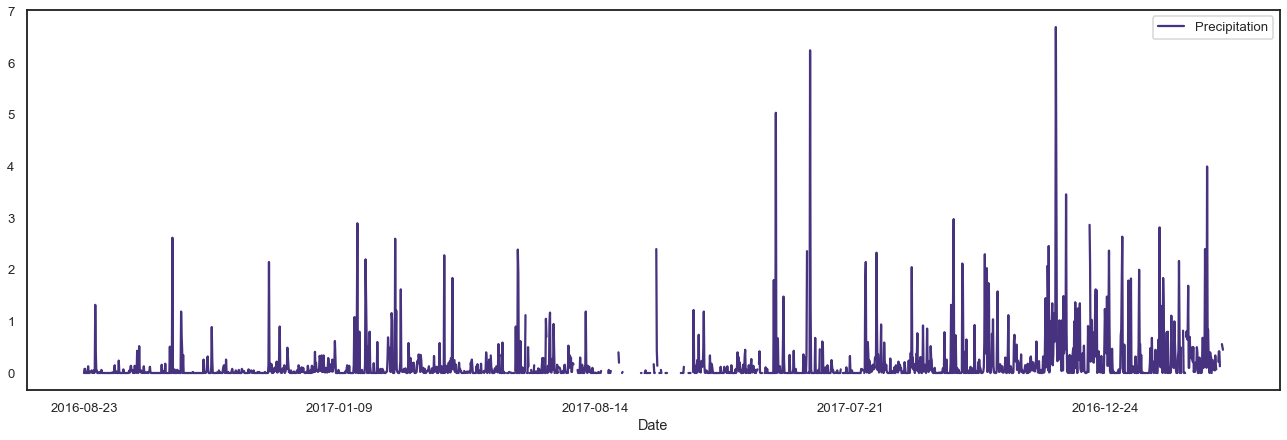

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation scores

prcp = session.query (Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()
# session.query (func.max(Measurement.date)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

prcp_df = pd.DataFrame(prcp,columns =['Date', 'Precipitation'])
prcp_df.set_index('Date', inplace=True)
prcp_df.head(3)

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot()


In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data

prcp_df.describe()

Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000

In [32]:
# Design a query to show how many stations are available in this dataset?
a = session.query(Station).count()
print(a)

9


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
act = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
act

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [34]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]
minmaxave = session.query(*sel).\
filter(Measurement.station == "USC00519281" ).\
order_by(Measurement.tobs).all()
minmaxave

[(54.0, 85.0, 71.66378066378067)]

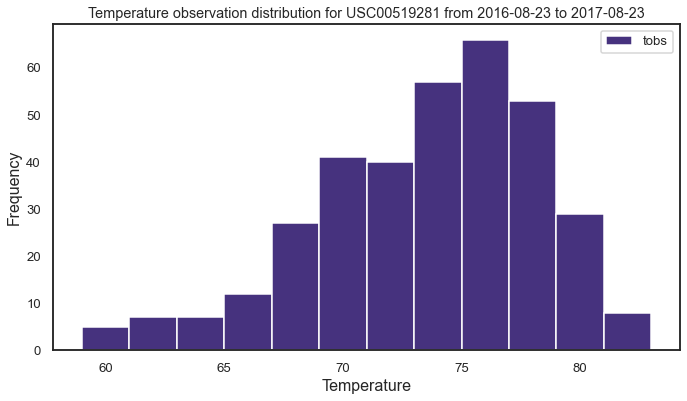

In [50]:
mm = act[0][0] # Choose the station with the highest number of temperature observations.

last_day_r = latest_day = dt.date(2017,8,23)
delta = last_day_r - dt.timedelta(days=365)
last_day = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

t = session.query(Measurement.tobs).filter(Measurement.date >= delta).\
    filter(Measurement.date <= last_day_r).\
    filter(Measurement.station == mm).all()


aaa = list(np.ravel(t))
plt.figure(figsize=(10,6))
plt.hist(aaa, bins=12)
plt.title("Temperature observation distribution for {0} from {1} to {2}".format(mm, delta,last_day_r))
plt.ylabel('Frequency', fontsize=16)
plt.xlabel('Temperature', fontsize=16)
labels = ['tobs']
plt.legend(labels)
plt.show()


## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [26]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [27]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [28]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [29]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [30]:
# Plot the daily normals as an area plot with `stacked=False`
